Plot the distribution of GMM

In [1]:
%matplotlib inline
import sys
import os
import copy
import json
from glob import glob

import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

import utility as util
from helper import load_model, prediction_output_to_trajectories
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

from model.components.discrete_latent import DiscreteLatent
from model.components.map_encoder import CNNMapEncoder
from model.dataset.preprocessing import get_node_timestep_data

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

Search for CARLA datasets

In [6]:
search_datasets = False
rootdir = "../../../.."
glob(f"{rootdir}/*/*.pkl") if search_datasets else []

[]

In [7]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset with bitmap mis-matched from NuScenes",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)

dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_6 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1-1_dataset/v3-1-1_split1_test.pkl",
        name='v3-1-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_8 = util.AttrDict(
    test_set_path=f"{rootdir}/carla_dataset_v4-1/v4-1_split1_test.pkl",
    name="v4-1",
    desc="CARLA 0.9.13 synthesized dataset all maps"
)

dataset_9 = util.AttrDict(
    test_set_path=f"{rootdir}/carla_dataset_v4-2-1/v4-2-1_split1_test.pkl",
    name="v4-2-1",
    desc="CARLA 0.9.13 synthesized dataset Town03 only"
)

dataset = dataset_9
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA 0.9.13 synthesized dataset Town03 only


Load NuScenes dataset

Search models

In [11]:
search_models = False
models_dir = "../models"
[x[0] for x in os.walk(models_dir)] if search_models else None

Load model

In [16]:
model_1 = util.AttrDict(
        path='../models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='../models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='../models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8, K=25 "
             "(trained on small carla v3-1 dataset)")

model_17 = util.AttrDict(
        path='../models/20210801/models_01_Aug_2021_20_02_57_carla_v3-1-1_base_distmapV3_ph8',
        desc="Base +MapV2 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_18 = util.AttrDict(
        path='../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_23  = util.AttrDict(
    path=f"{models_dir}/20220326/models_26_Mar_2022_23_31_28_carla_v4-1_base_distmapV4_modfm_K15_ph8",
    desc="Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 all maps)"
)

model_24  = util.AttrDict(
    path=f"{models_dir}/20220326/models_27_Mar_2022_04_52_55_carla_v4-2-1_base_distmapV4_modfm_K15_ph8",
    desc="Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 Town03)"
)

model = model_24
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20220326/models_27_Mar_2022_04_52_55_carla_v4-2-1_base_distmapV4_modfm_K15_ph8/model_registrar-20.pt
Loaded!

Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 Town03)


In [18]:
hyp['MLP_dropout_keep_prob']
c = DiscreteLatent.all_one_hot_combinations(2,3)
c.shape
hyp['state'], hyp['map_encoder']['VEHICLE']

({'VEHICLE': {'position': ['x', 'y'],
   'velocity': ['x', 'y'],
   'acceleration': ['x', 'y'],
   'heading': ['°', 'd°', 'x', 'y']}},
 {'name': 'CNNMapEncoderV3',
  'heading_state_index': 6,
  'patch_size': [70, 20, 70, 120],
  'map_channels': 3,
  'output_size': 100,
  'hidden_channels': [12, 24, 48, 4],
  'masks': [5, 5, 3, 1],
  'strides': [2, 2, 1, 1],
  'poolings': ['max', 'max', None, None],
  'apply_last_cnn_activation': False,
  'has_fc': False,
  'dropout': 0.5})

### Combining forecast and map

In [19]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

In [20]:
scene = eval_scenes[3]

ph = 8
num_samples = 100
timestep = 16
timesteps = np.array([timestep])

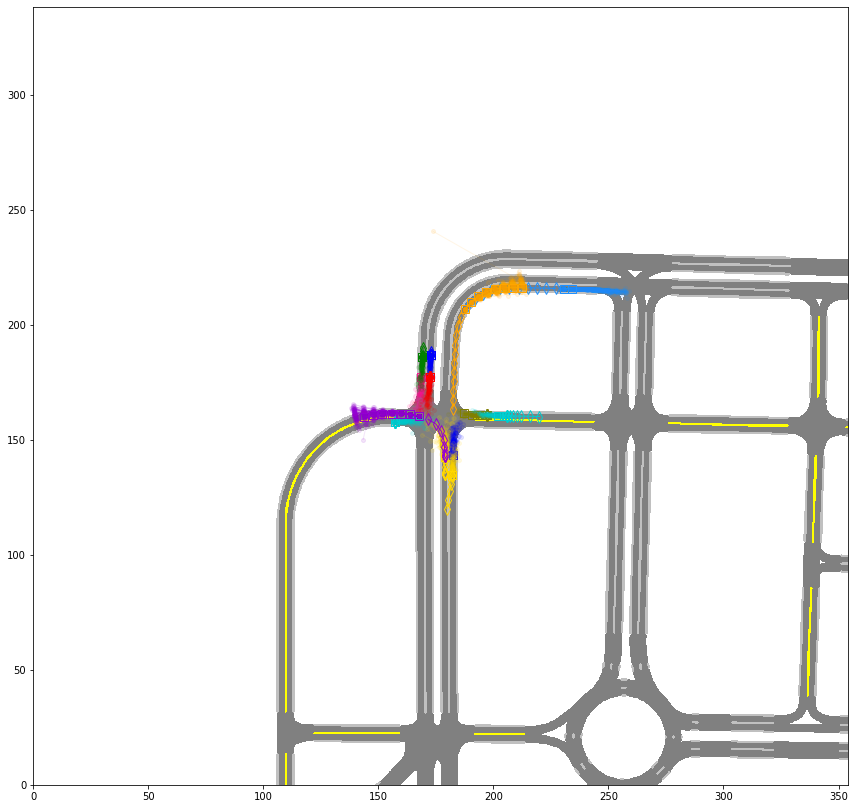

In [21]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[timestep][node]
    player_past = histories_dict[timestep][node]
    player_predict = prediction_dict[timestep][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
None

Inspect data processing in training

In [54]:
_hyp = copy.deepcopy(hyp)
print("Map crop dimensions hyperparameter")
print(_hyp['map_encoder']['VEHICLE']['patch_size'])

Map crop dimensions hyperparameter
[70, 20, 70, 120]


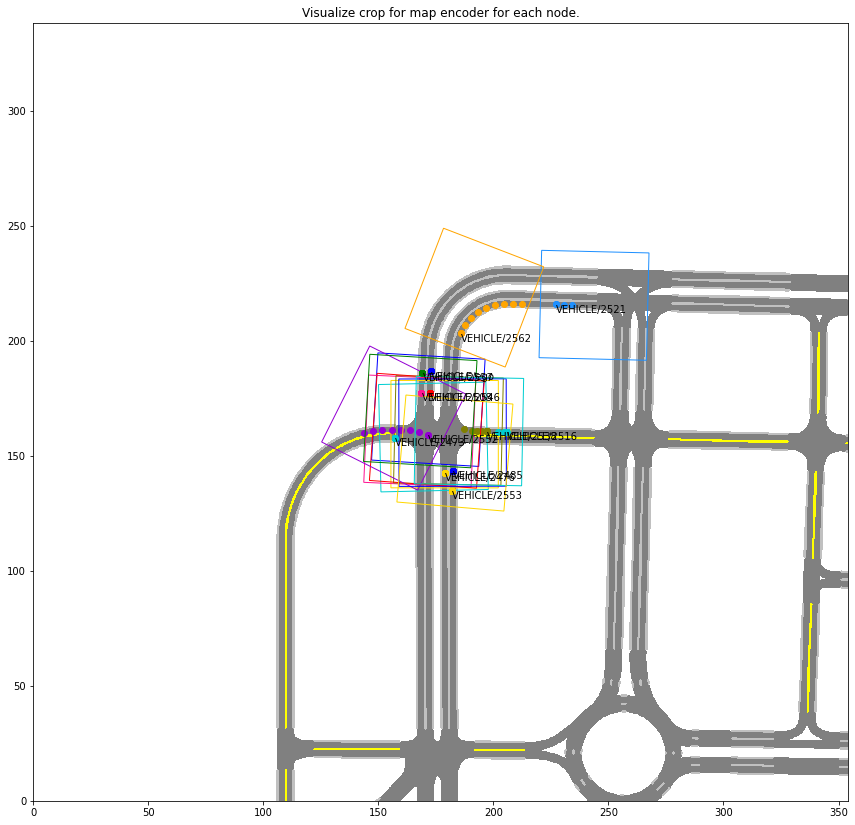

In [58]:
_hyp = copy.deepcopy(hyp)
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

alt_patch_size = None

for idx, node in enumerate(v_nodes):
    # Get node current position at timestep
    x, y = node.get(np.array([timestep]), {'position': ['x', 'y']}).squeeze()
    ax.plot(x, y, marker='o', color=AGENT_COLORS[idx % NCOLORS])
    
    # Get node ground truth future positions
    state = [('position', 'x'), ('position', 'y')]
    gt_range = np.array([timestep, timestep + ph])
    gt = node.get(gt_range, state).T
    ax.scatter(gt[0], gt[1], color=AGENT_COLORS[idx % NCOLORS])
    
    # Extract map crop information from node timestep data, and plot on map.
    state = _hyp['state']
    pred_state = _hyp['pred_state']
    edge_types = eval_env.get_edge_types()
    max_ht = _hyp['maximum_history_length']
    max_ft = _hyp['prediction_horizon']
    _, _, _, _, _, _, _, _, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types,
                                     max_ht, max_ft, _hyp)
    scene_map, map_point, heading_angle, patch_size = map_tuple
    min_x, min_y, max_x, max_y = patch_size
    # Must divide by 3 due to homography?
    min_x, min_y = -min_x / 3, -min_y / 3
    max_x, max_y = max_x / 3, max_y / 3
    # Must add 90 deg, why?
    mtx = util.rotation_2d(np.deg2rad(heading_angle + 90))
    rect = np.array([
            [max_x, max_y],
            [max_x, min_y],
            [min_x, min_y],
            [min_x, max_y]])
    rect = rect @ mtx.T + map_point
    patch = patches.Polygon(rect, fill=False, color=AGENT_COLORS[idx % NCOLORS])
    ax.add_patch(patch)
    ax.text(x, y - 3.5, str(node))
ax.set_title("Visualize crop for map encoder for each node.")
fig.tight_layout()

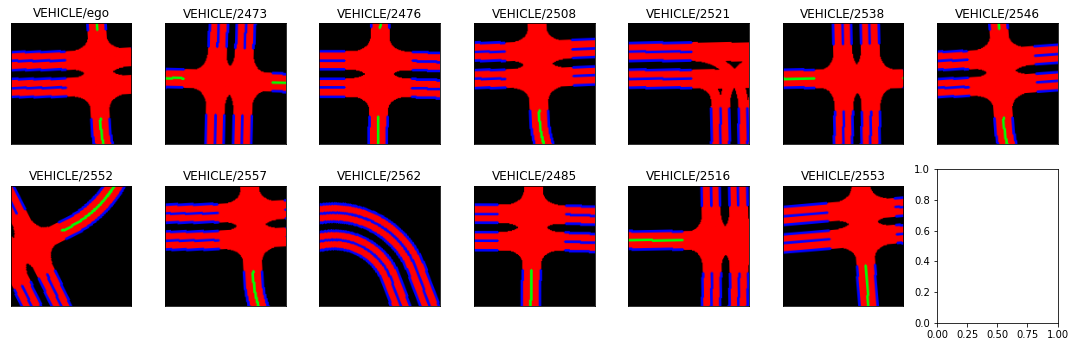

In [59]:
# Visualize map encoder input for each node
_hyp = copy.deepcopy(hyp)
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, axes = plt.subplots(2, len(v_nodes) // 2 + len(v_nodes) % 2, figsize=(15,5))
axes = axes.ravel()

for idx, node in enumerate(v_nodes):
    # Extract map crop information from node timestep data, and show.
    state = _hyp['state']
    pred_state = _hyp['pred_state']
    edge_types = eval_env.get_edge_types()
    max_ht = _hyp['maximum_history_length']
    max_ft = _hyp['prediction_horizon']
    _, _, _, _, _, _, _, _, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types,
                                     max_ht, max_ft, _hyp)
    scene_map, map_point, heading_angle, patch_size = map_tuple
    cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                           rotation=torch.Tensor([heading_angle]), device='cpu')
    _cropped_map = cropped_map.squeeze().permute(2,1,0).detach().numpy()
    axes[idx].imshow(_cropped_map, origin='lower')
    axes[idx].set_title(repr(node))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

fig.tight_layout()

Describe full model

In [50]:
print(eval_stg.model_registrar)

ModelRegistrar(
  (model_dict): ModuleDict(
    (VEHICLE/node_history_encoder): LSTM(10, 32, batch_first=True)
    (VEHICLE/node_future_encoder): LSTM(2, 32, batch_first=True, bidirectional=True)
    (VEHICLE/node_future_encoder/initial_h): Linear(in_features=10, out_features=32, bias=True)
    (VEHICLE/node_future_encoder/initial_c): Linear(in_features=10, out_features=32, bias=True)
    (VEHICLE/edge_influence_encoder): AdditiveAttention(
      (w1): Linear(in_features=32, out_features=32, bias=False)
      (w2): Linear(in_features=32, out_features=32, bias=False)
      (v): Linear(in_features=32, out_features=1, bias=False)
    )
    (VEHICLE/map_encoder): CNNMapEncoderV3(
      (convs): Sequential(
        (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=

In [51]:
col_names = ("num_params", "kernel_size")
torchinfo.summary(eval_stg.model_registrar.model_dict, col_names=col_names)

Layer (type:depth-idx)                   Param #                   Kernel Shape
ModuleDict                               --                        --
├─LSTM: 1-1                              5,632                     --
├─LSTM: 1-2                              9,216                     --
├─Linear: 1-3                            352                       [10, 32]
├─Linear: 1-4                            352                       [10, 32]
├─AdditiveAttention: 1-5                 --                        --
│    └─Linear: 2-1                       1,024                     [32, 32]
│    └─Linear: 2-2                       1,024                     [32, 32]
│    └─Linear: 2-3                       32                        [32, 1]
├─CNNMapEncoderV3: 1-6                   --                        --
│    └─Sequential: 2-4                   --                        --
│    │    └─Conv2d: 3-1                  912                       [3, 12, 5, 5]
│    │    └─ReLU: 3-2                   

Inspect CNNMapEncoder hidden layers

visualizing node VEHICLE/2521
map input range [0.0, 1.0]
layer 1 activations; shape [12, 68, 68]
layer 2 activations; shape [24, 15, 15]
layer 3 activations; shape [48, 5, 5]
layer 4 before activations; shape [4, 5, 5]


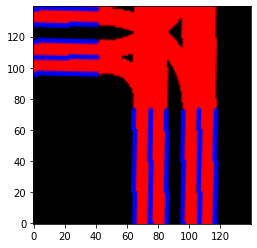

In [147]:
# visualizing the last layer of the CNN network
_hyp = copy.deepcopy(hyp)
eval_model = eval_stg.node_models_dict['VEHICLE']
map_encoder = eval_model.node_modules['VEHICLE/map_encoder']
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
node = v_nodes[3]
print("visualizing node", node)

# Extract map crop information from node timestep data, and plot on map.
state = _hyp['state']
pred_state = _hyp['pred_state']
edge_types = eval_env.get_edge_types()
max_ht = _hyp['maximum_history_length']
max_ft = _hyp['prediction_horizon']
_, _, _, _, _, _, _, _, map_tuple \
        = get_node_timestep_data(eval_env, scene, timestep, node, 
                                 state, pred_state, edge_types,
                                 max_ht, max_ft, _hyp)
scene_map, map_point, heading_angle, patch_size = map_tuple
cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                       rotation=torch.Tensor([heading_angle]), device='cpu')
_cropped_map = cropped_map.squeeze().permute(1,2,0).detach().numpy()
plt.imshow(_cropped_map, origin='lower')
print("map input range", [_cropped_map.min(), _cropped_map.max()])

# Visualization code for hidden layers expects map encoder to have this 
"""
(VEHICLE/map_encoder): CNNMapEncoderV3(
      (convs): Sequential(
        (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
        (7): ReLU()
        (8): Conv2d(48, 4, kernel_size=(1, 1), stride=(1, 1))
        (9): Flatten(start_dim=1, end_dim=-1)
      )
)"""

with torch.no_grad():
    z = map_encoder.convs[0](cropped_map)
    z_1 = z.squeeze(0).cpu().detach().numpy()
    h = map_encoder.convs[1](z)
    inter_1 = h.squeeze(0).cpu().detach().numpy()
    print("layer 1 activations; shape", list(inter_1.shape))
    
    z = map_encoder.convs[2](h)
    z = map_encoder.convs[3](z)
    z_2 = z.squeeze(0).cpu().detach().numpy()
    h = map_encoder.convs[4](z)
    inter_2 = h.squeeze(0).cpu().detach().numpy()
    print("layer 2 activations; shape", list(inter_2.shape))
    
    z = map_encoder.convs[5](h)
    z = map_encoder.convs[6](z)
    z_3 = z.squeeze(0).cpu().detach().numpy()
    h = map_encoder.convs[7](z)
    inter_3 = h.squeeze(0).cpu().detach().numpy()
    print("layer 3 activations; shape", list(inter_3.shape))
    
    z = map_encoder.convs[8](h)
    inter_4 = z.squeeze(0).cpu().detach().numpy()
    print("layer 4 before activations; shape", list(inter_4.shape))

pre activation ranges [-1.2009668, 1.8792983]
activation ranges [0.0, 1.8792983]


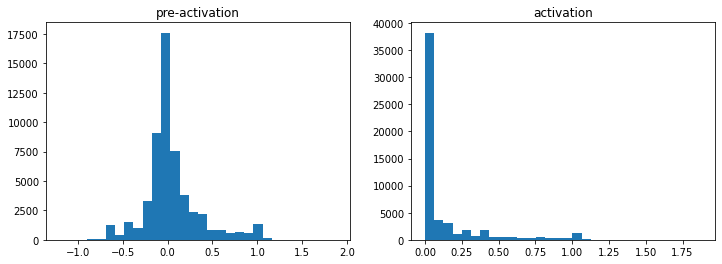

In [136]:
_z = z_1.reshape(-1)
_inter = inter_1.reshape(-1)
e_min = _z.min()
e_max = _z.max()
print("pre activation ranges", [e_min, e_max])
e_min = _inter.min()
e_max = _inter.max()
print("activation ranges", [e_min, e_max])
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(_z, bins=30); axes[0].set_title("pre-activation")
axes[1].hist(_inter, bins=30); axes[1].set_title("activation")
None

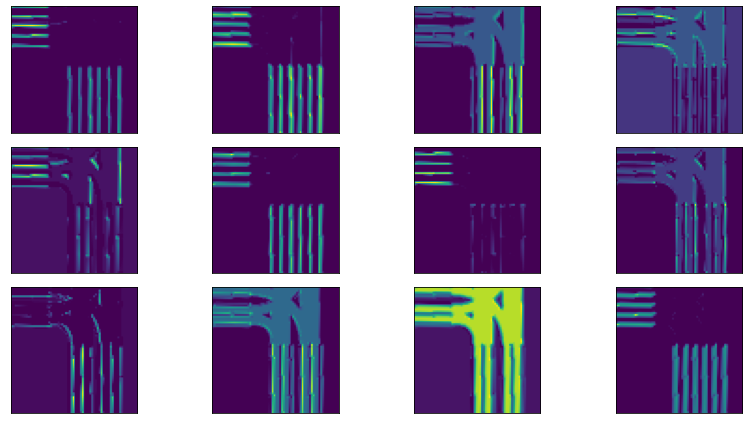

In [137]:
# Layer 1 activations
_inter = inter_1
channels = _inter.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(12, 6))
axes = axes.ravel()

for i, h in enumerate(_inter):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

pre activation ranges [-5.240753, 0.5877292]
activation ranges [0.0, 0.5877292]


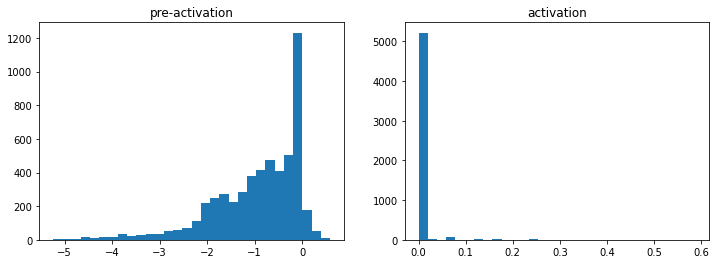

In [138]:
_z = z_2.reshape(-1)
_inter = inter_2.reshape(-1)
e_min = _z.min()
e_max = _z.max()
print("pre activation ranges", [e_min, e_max])
e_min = _inter.min()
e_max = _inter.max()
print("activation ranges", [e_min, e_max])
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(_z, bins=30); axes[0].set_title("pre-activation")
axes[1].hist(_inter, bins=30); axes[1].set_title("activation")
None

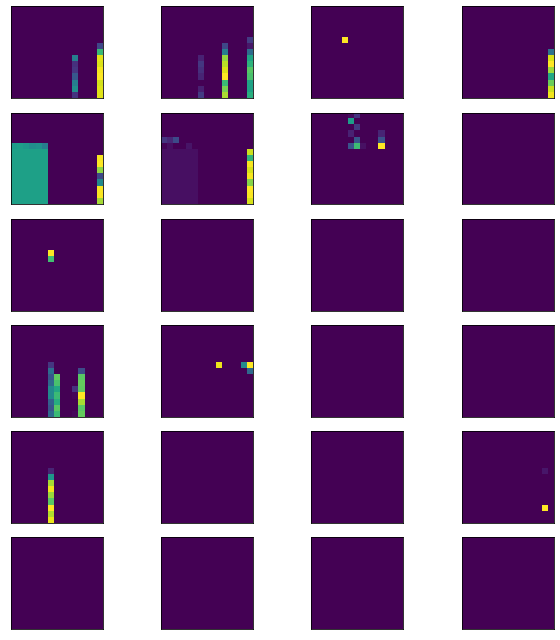

In [139]:
# Layer 2 activations
_inter = inter_2
channels = _inter.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(9, 9))
axes = axes.ravel()

for i, h in enumerate(_inter):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

pre activation ranges [-0.34328577, 0.15959439]
activation ranges [0.0, 0.15959439]


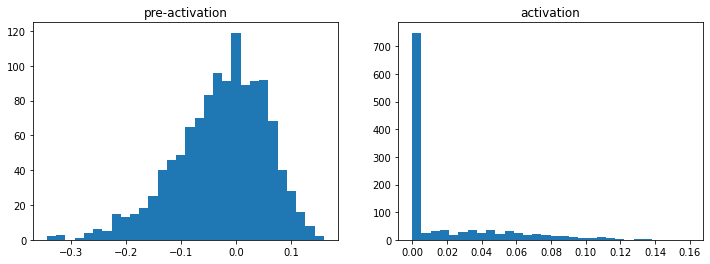

In [140]:
_z = z_3.reshape(-1)
_inter = inter_3.reshape(-1)
e_min = _z.min()
e_max = _z.max()
print("pre activation ranges", [e_min, e_max])
e_min = _inter.min()
e_max = _inter.max()
print("activation ranges", [e_min, e_max])
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(_z, bins=30); axes[0].set_title("pre-activation")
axes[1].hist(_inter, bins=30); axes[1].set_title("activation")
None

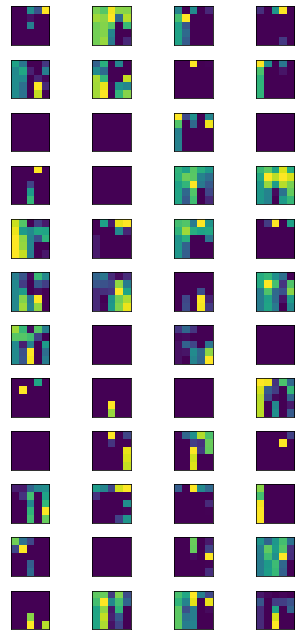

In [141]:
_inter = inter_3
channels = _inter.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(5, 9))
axes = axes.ravel()

for i, h in enumerate(_inter):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

pre-activation ranges [-0.052493837, 0.058529235]


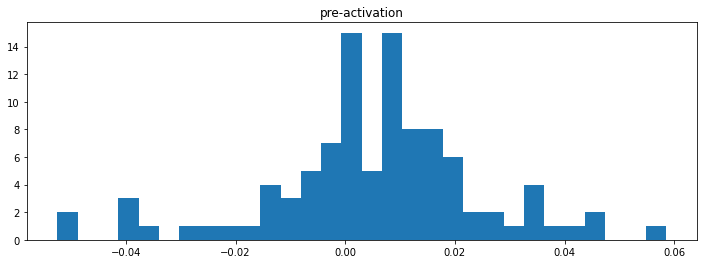

In [142]:
_inter = inter_4.reshape(-1)
e_min = _inter.min()
e_max = _inter.max()
print("pre-activation ranges", [e_min, e_max])
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.hist(_inter, bins=30); ax.set_title("pre-activation")
None

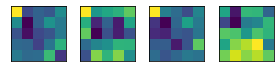

In [134]:
_inter = inter_4
channels = _inter.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(4,6))
axes = axes.ravel()

for i, h in enumerate(_inter):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

Inspect CNNMapEncoderV3 hidden features

In [106]:
map_encoder = eval_stg.model_registrar.model_dict['VEHICLE/map_encoder']
col_names = ("num_params", "kernel_size")
torchinfo.summary(map_encoder, col_names=col_names)

Layer (type:depth-idx)                   Param #                   Kernel Shape
CNNMapEncoderV3                          --                        --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       912                       [3, 12, 5, 5]
│    └─ReLU: 2-2                         --                        --
│    └─MaxPool2d: 2-3                    --                        --
│    └─Conv2d: 2-4                       7,224                     [12, 24, 5, 5]
│    └─ReLU: 2-5                         --                        --
│    └─MaxPool2d: 2-6                    --                        --
│    └─Conv2d: 2-7                       10,416                    [24, 48, 3, 3]
│    └─ReLU: 2-8                         --                        --
│    └─Conv2d: 2-9                       196                       [48, 4, 1, 1]
│    └─Flatten: 2-10                     --                        --
Total params: 18,748
Trainable par